In [1]:
!pip install transformers torch math

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [9]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import math

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)  # Move model to GPU
model.eval()

def calculate_perplexity(sentence):
    inputs = tokenizer(sentence, return_tensors='pt').to(device)  # Move inputs to GPU
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
    return math.exp(loss.item())

sentence = "Our plan is therefore to 1) rephrase the execution trace as a polynomial, 2) extend it to a large domain, and 3) transform that, using the polynomial constraints, into yet another polynomial that is guaranteed to be of low degree if and only if the execution trace is valid."
print("Perplexity:", calculate_perplexity(sentence))


Perplexity: 20.91058119547784


In [3]:
folder  = "/content/drive/MyDrive/responses"

# LogicBench


In [4]:
import json


In [ ]:
models = ["claude.json", "mistral.json", "gpt4o.json"]

In [10]:
# subfolder = ["logicbench/exp-3","logicbench/irr"]



def load_predictions(predictions_path):
    predicted_answers = []
    with open(predictions_path, 'r') as f:
        predicted_data = json.load(f)
        for item in predicted_data["data_samples"]:
          sentence = item.get("context")
          for qa in item['qa_pairs']:
              answer = qa.get('question', '')
              # if isinstance(answer, list):  # If the answer is a list, pick the first element
              #     answer = answer[0] if answer else ''
              if isinstance(answer, (int, float)):  # Convert numeric answers to strings
                  answer = str(answer)
              elif not isinstance(answer, str):  # Skip non-string and non-numeric answers
                continue
              sentence = sentence + answer
              predicted_answers.append(sentence)
    return predicted_answers
result ={}
sentences = load_predictions("/content/exp_3.json")
perplexity = 0
for sent in sentences:
  perplexity+=calculate_perplexity(sent)
result["exp-3"] = {
    "perplexity": perplexity/len(sentences)
}
sentences = load_predictions("/content/irr.json")
perplexity = 0
for sent in sentences:
  perplexity+=calculate_perplexity(sent)
result["irr"] = {
    "perplexity": perplexity/len(sentences)
}
print(perplexity/len(sentences))




29.922496293985215


# LogicQA

In [11]:
def load_ground_truth(logicqa_path):
    ground_truth_answers = []
    with open(logicqa_path, 'r') as f:
        for line in f:
            try:
                obj = json.loads(line.strip())
                answer = obj.get('text', '') + obj.get('question', '') + str(obj.get('options', ''))
                if isinstance(answer, (int, float)):
                    answer = str(answer)
                elif not isinstance(answer, str):
                    continue
                # answer = answer.strip().lower()
                if answer:
                    ground_truth_answers.append(answer)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()} - Error: {e}")
    return ground_truth_answers
sentences = load_ground_truth("/content/LogicQA.jsonl")
perplexity = 0
for sent in sentences:
  perplexity+=calculate_perplexity(sent)
result["logicqa"] = {
    "perplexity": perplexity/len(sentences)
}



# LogicQA2


In [12]:
def load_ground_truth(logicqa_path):
    ground_truth_answers = []
    with open(logicqa_path, 'r') as f:
        for line in f:
            try:
                obj = json.loads(line.strip())
                answer = str(obj.get('major_premise', '')) + obj.get('conclusion', '') + obj.get('minor_premise', '')
                if isinstance(answer, (int, float)):
                    answer = str(answer)
                elif not isinstance(answer, str):
                    continue
                # answer = answer.strip().lower()
                if answer:
                    ground_truth_answers.append(answer)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()} - Error: {e}")
    return ground_truth_answers
sentences = load_ground_truth("/content/LogicQA2.jsonl")
perplexity = 0
for sent in sentences:
  perplexity+=calculate_perplexity(sent)
result["logicqa2"] = {
    "perplexity": perplexity/len(sentences)
}



In [13]:
with open('/content/perplexity_results.json', 'w') as f:
    json.dump(result, f, indent=4)


In [15]:
folder = "/content/"
filename = "accuracy_results_"
ext = ".json"

In [21]:
import os
os.makedirs(f"{folder}plots", exist_ok=True)

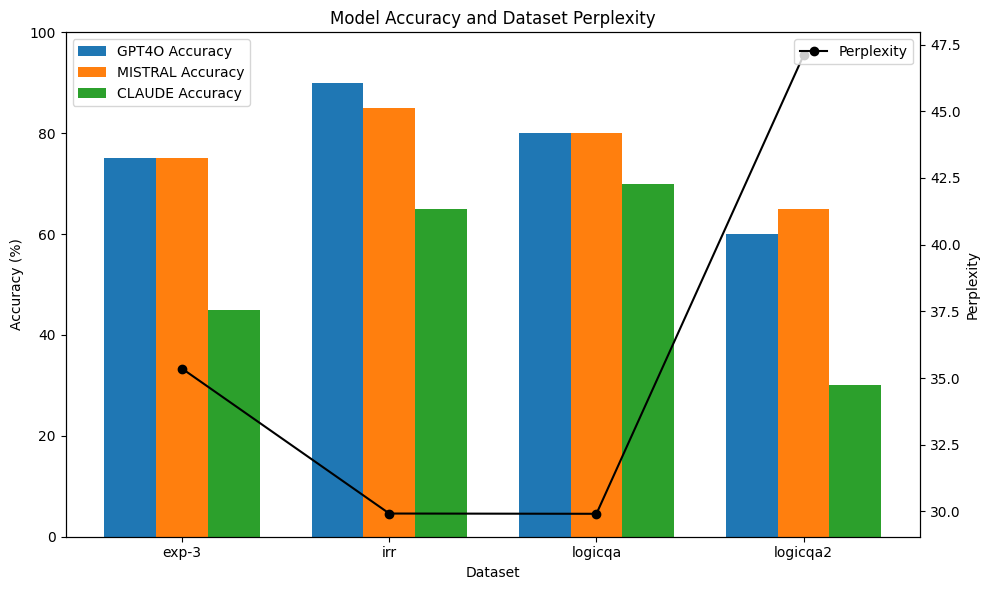

In [22]:
# import json
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data from each file
accuracy_data = {
    "exp-3": {"gpt4o": 75.0, "mistral": 75.0, "claude": 45.0},
    "irr": {"gpt4o": 90.0, "mistral": 85.0, "claude": 65.0},
    "logicqa": {"gpt4o": 80.0, "mistral": 80.0, "claude": 70.0},
    "logicqa2": {"gpt4o": 60.0, "mistral": 65.0, "claude": 30.0},
}

# Perplexity data
perplexity_data = {
    "exp-3": 35.35,
    "irr": 29.92,
    "logicqa": 29.91,
    "logicqa2": 47.10
}

datasets = list(accuracy_data.keys())
models = ["gpt4o", "mistral", "claude"]

# Set up bar positions
x = np.arange(len(datasets))
width = 0.25

# Bar positions for each model
offsets = {
    "gpt4o": -width,
    "mistral": 0,
    "claude": width
}

# Plot accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

for model in models:
    acc_values = [accuracy_data[ds][model] for ds in datasets]
    ax1.bar(x + offsets[model], acc_values, width, label=f'{model.upper()} Accuracy')

ax1.set_xlabel('Dataset')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Model Accuracy and Dataset Perplexity')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')

# Twin axis for perplexity
ax2 = ax1.twinx()
perplexity_values = [perplexity_data[ds] for ds in datasets]
ax2.plot(x, perplexity_values, color='black', marker='o', label='Perplexity')
ax2.set_ylabel('Perplexity')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{folder}plots/accuracy_perplexity.png")
plt.show()


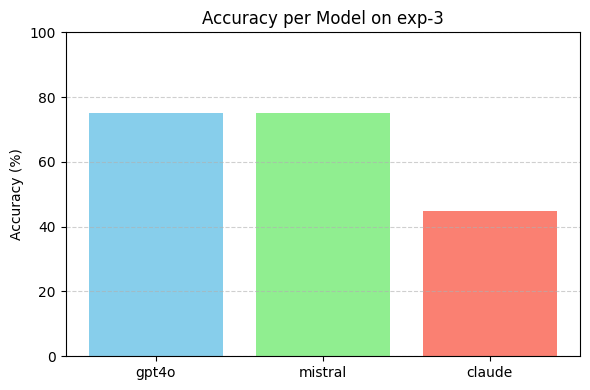

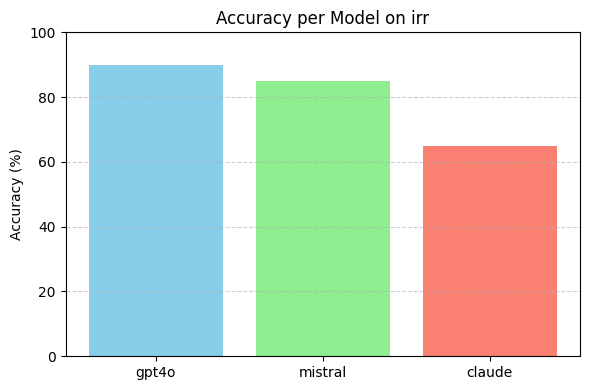

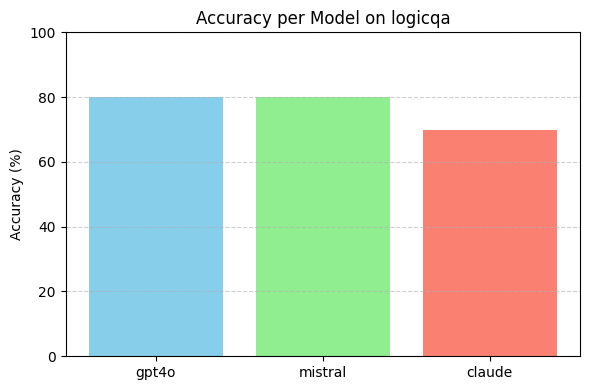

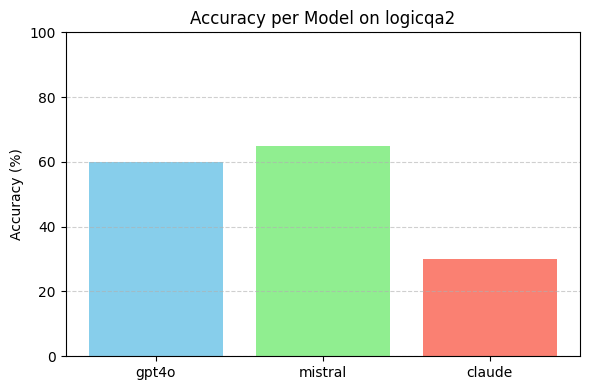

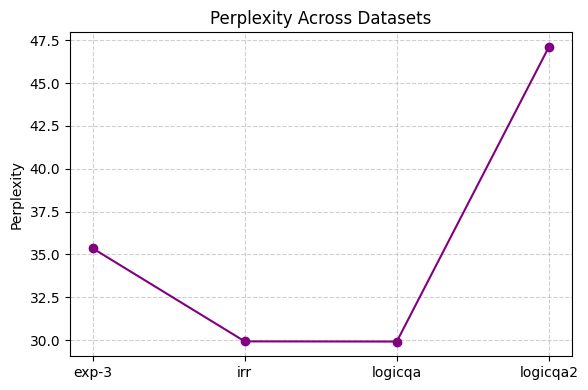

In [23]:
# Plot separate bar charts for each dataset
for dataset, results in accuracy_data.items():
    plt.figure(figsize=(6, 4))
    plt.bar(results.keys(), results.values(), color=["skyblue", "lightgreen", "salmon"])
    plt.ylim(0, 100)
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy per Model on {dataset}")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{folder}plots/accuracy_{dataset}.png")
    plt.show()

# Plot perplexity across datasets
plt.figure(figsize=(6, 4))
plt.plot(perplexity_data.keys(), perplexity_data.values(), marker='o', linestyle='-', color='purple')
plt.ylabel("Perplexity")
plt.title("Perplexity Across Datasets")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{folder}plots/perplexity.png")
plt.show()

In [25]:
from scipy.stats import spearmanr

# Calculate Spearman correlation between accuracy and perplexity for each model
for model in models:
    acc_values = [accuracy_data[ds][model] for ds in datasets]
    perplexity_values = [perplexity_data[ds] for ds in datasets]
    correlation, p_value = spearmanr(acc_values, perplexity_values)
    print(f"Spearman correlation for {model.upper()} vs Perplexity: {correlation:.4f} (p={p_value:.4f})")


Spearman correlation for GPT4O vs Perplexity: -0.8000 (p=0.2000)
Spearman correlation for MISTRAL vs Perplexity: -0.8000 (p=0.2000)
Spearman correlation for CLAUDE vs Perplexity: -1.0000 (p=0.0000)
